## SHOT CLASSIFICATION

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from classifier.shot_inference import ShotInference
import cv2

Using TensorFlow backend.


In [2]:
model_path = 'saved_model/shot_classifier'
image_path = 'testset/'
image_names = os.listdir(image_path)
label_path = 'testset/output_detection_info.csv'

shots = ['smash', 'drop', 'defense', 'backhand']
label = pd.read_csv(label_path, header=None)

inf_model = ShotInference(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


[0]


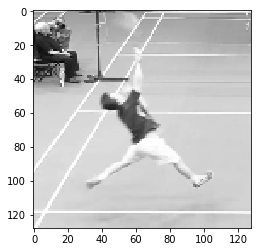

[1]


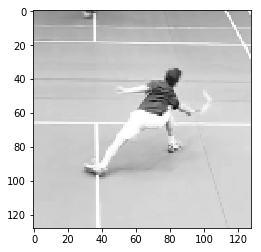

[0]


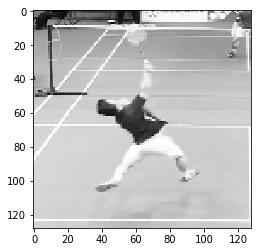

[3]


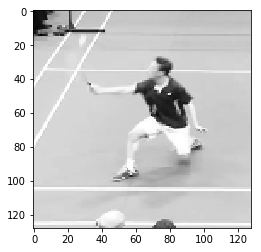

In [15]:
classification_result = {}
cropped_frames = {}
for img in image_names:
    if img.endswith('png'):
        full_image_path = os.path.join(image_path, img)
        row = label.loc[label[0] == img]
        bbox = (row[2].values[0], row[3].values[0], row[4].values[0], row[5].values[0]) # xmin, ymin, xmax, ymax
        
        shot, frame = inf_model.predict(0, full_image_path, bbox)
        plt.imshow(np.squeeze(frame), cmap='gray')
        print(shot)
        plt.show()
        
        classification_result[img] = shot[0]
        cropped_frames[img] = frame

## POSE ESTIMATION

In [4]:
from open_pose_model.pose_predictor import Pose_predictor

C:\Users\swlee\Desktop\badminton-pose-analysis


In [5]:
pose_model_path = 'saved_model/keras_openpose_model.h5'
output_path = 'skeleton/'
pose_detector = Pose_predictor(pose_model_path)

C:\Users\swlee\Desktop\badminton-pose-analysis
{'param': {'use_gpu': '1', 'GPUdeviceNumber': '0', 'modelID': '1', 'octave': '3', 'starting_range': '0.8', 'ending_range': '2', 'scale_search': ['0.5', '1', '1.5', '2'], 'thre1': '0.1', 'thre2': '0.05', 'thre3': '0.5', 'min_num': '4', 'mid_num': '10', 'crop_ratio': '2.5', 'bbox_ratio': '0.25'}, 'models': {'1': {'caffemodel': './model/_trained_COCO/pose_iter_440000.caffemodel', 'deployFile': './model/_trained_COCO/pose_deploy.prototxt', 'description': 'COCO Pose56 Two-level Linevec', 'boxsize': '368', 'padValue': '128', 'np': '12', 'stride': '8', 'part_str': ['[nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb', 'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 'Leye', 'Reye', 'Lear', 'Rear', 'pt19]']}}}


start processing...
processing time is 8.51914


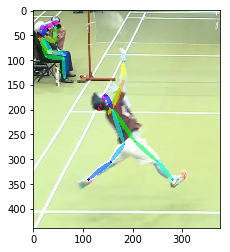

start processing...
processing time is 7.52991


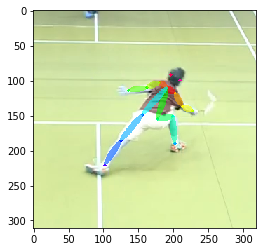

start processing...
processing time is 5.97215


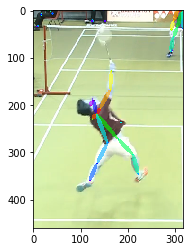

start processing...
processing time is 6.73053


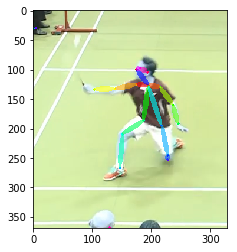

In [6]:
skeleton_frames = {}
skeleton_images = {}
for img in image_names:
    if img.endswith(".png"):
        full_image_path = os.path.join(image_path,img)
        result,skeleton_img = pose_detector.single_predictor(full_image_path,output_path,label_path)
        skeleton_frames[img] = result
        skeleton_images[img] = skeleton_img
        plt.imshow(skeleton_img)
        plt.show()

## HOMOGRAPHIC TRANSFORMATION

### Evaluations

In [7]:
from skeleton_matching.perspective_transform import PerspectiveTransform
import utils.angle as angle
import pandas as pd

In [8]:
professional = pd.read_csv('best_shot.csv', header=None)
professional

,0,1,2,3,4
0,LCW,smash,175.815084,18.662312,24.151887
1,LCW,backhand,0.000000,19.849372,12.724356


angles calculated = (0.36493633573052764, 89.68403383071161, 83.31131892799392)


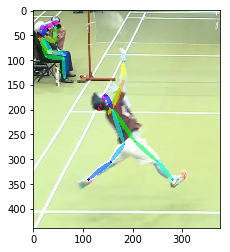

unlabelled_TEST_Test1_4
lunge distance = 1.1506406348519551


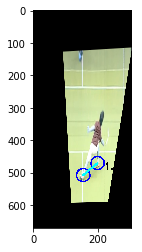

angles calculated = (129.70741995998804, 68.62937773065681, 5.846511272588976)


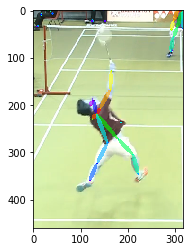

angles calculated = (2.8201724724484656, 18.239400846651158, 10.892230667534795)


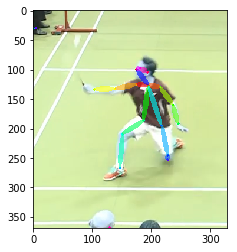

In [9]:
pt = PerspectiveTransform()

for img in image_names:
    if img.endswith(".png"):
        if(classification_result[img] == 1 or classification_result[img] == 2):
            full_image_path = os.path.join(image_path,img)
            wr_img = pt.warp_homography_perspective(full_image_path)

            sk_info = skeleton_frames[img]
            dist, wr_img2 = pt.get_lunge_distance2(full_image_path, sk_info)

            plt.imshow(wr_img2)
            print("lunge distance =",dist)
            plt.show()
        else:
            sk_info = skeleton_frames[img]
            only_name = os.path.splitext(img)[0]
            th = angle.calculate_angle(sk_info[only_name][0])
            
            plt.imshow(skeleton_images[img])
            print("angles calculated =", th)
            plt.show()